In [304]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_syn_images(image_dir, channel=0):
    files = os.listdir(image_dir)
    #files = [os.path.join(image_dir, f) for f in files]
    nfiles = len(files)
    
    image_stack = None
    V = 0
    Z = 0.5
    
    for i in range(nfiles):
        # read input image
        im = cv2.imread(os.path.join(image_dir, files[i]), cv2.IMREAD_COLOR)
        im = im[:,:,channel]
        
        # stack at third dimension
        if image_stack is None:
            h, w = im.shape
            print('Image size (H*W): %d*%d' %(h,w) )
            image_stack = np.zeros([h, w, nfiles], dtype=int)
            V = np.zeros([nfiles, 3], dtype=np.float64)
            
        image_stack[:,:,i] = im
        
        # read light direction from image name
        X = np.double(files[i][(files[i].find('_')+1):files[i].rfind('_')])
        Y = np.double(files[i][files[i].rfind('_')+1:files[i].rfind('.png')])
        V[i, :] = [-X, Y, Z]
        
    # normalization
    image_stack = np.double(image_stack)
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    normV = np.tile(np.sqrt(np.sum(V ** 2, axis=1, keepdims=True)), (1, V.shape[1]))
    scriptV = V / normV
    
    return image_stack, scriptV
    
    
def load_face_images(image_dir='./yaleB02/'):
    num_images = 64
    filename = os.path.join(image_dir, 'yaleB02_P00_Ambient.pgm')
    ambient_image = cv2.imread(filename, -1)
    h, w = ambient_image.shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'yaleB02_P00A*.pgm'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        ang[0,j], ang[1,j] = np.double(filenames[j][12:16]), np.double(filenames[j][17:20])
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1) - ambient_image


    x = np.cos(np.pi*ang[1,:]/180) * np.cos(np.pi*ang[0,:]/180)
    y = np.cos(np.pi*ang[1,:]/180) * np.sin(np.pi*ang[0,:]/180)
    z = np.sin(np.pi*ang[1,:]/180)
    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV
    
    
def show_results(albedo, normals, height_map, SE):
    # Stride in the plot, you may want to adjust it to different images
    stride = 1
    
    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo_max = 1
    albedo = albedo / albedo_max
    print(albedo.shape)
    plt.imshow(albedo, cmap="gray")
#     plt.savefig('albedo_face')
    plt.show()
    
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
#     plt.savefig('normal_face')
    plt.show()
    
    # meshgrid
    fig = plt.figure()
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
    np.arange(0,np.shape(normals)[1], stride),
    np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    
    
    '''
    =============
    You could further inspect the shape of the objects and normal directions by using plt.quiver() function.  
    =============
    '''
    ax4 = fig.gca(projection='3d')

    x = X[::10,::10]
    y = Y[::10,::10]
    print("x", x)
    
    h, w = height_map[::20, ::20].shape
    x, y = np.meshgrid(np.arange(w),
                       np.arange(h))
    z = np.nan_to_num(height_map[::20, ::20])
    u = np.nan_to_num(normals[::20, ::20, 0])
    v = np.nan_to_num(normals[::20, ::20, 1])
    w = np.nan_to_num(normals[::20, ::20, 2])

    ax4.quiver(x, y, z, -u, -v, w, length=3)
    ax4.set_zlim(0,50)
    ax4.view_init(23, 49)

#     plt.savefig('quiver_mokey_gray')
    plt.show()
    
    # plotting the SE
    H = SE[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
#     plt.savefig("SE_mokey_gray")
    plt.show()
    
    # plotting model geometry
    H = height_map[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
#     plt.savefig("height_map_row_face")
    plt.show()


Loading images...

Image size (H*W): 512*512
Finish loading 25 images.

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0.

<ipython-input-281-b49bfe01ee62>:55: RuntimeWarning: invalid value encountered in true_divide
  normal[i,j] = (g / np.linalg.norm(g)).T


(512, 512) (512, 512, 3)
(512, 512)


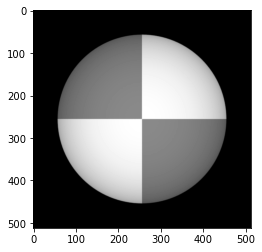

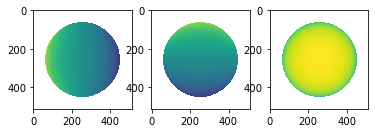

In [281]:
import numpy as np
import matplotlib.pyplot as plt
# import cv2

def estimate_alb_nrm( image_stack, scriptV, shadow_trick):
    
    # COMPUTE_SURFACE_GRADIENT compute the gradient of the surface
    # INPUT:
    # image_stack : the images of the desired surface stacked up on the 3rd dimension
    # scriptV : matrix V (in the algorithm) of source and camera information
    # shadow_trick: (true/false) whether or not to use shadow trick in solving linear equations
    # OUTPUT:
    # albedo : the surface albedo
    # normal : the surface normal

    h, w, _ = image_stack.shape
    
    # create arrays for 
    # albedo (1 channel)
    # normal (3 channels)
    albedo = np.zeros([h, w])
    normal = np.zeros([h, w, 3])

#     for x in range(h):
#         for y in range(w):
# #             i = np.array(image_stack[x,y]).reshape(-1,1)
            
# #             scriptI = np.diag(i.T[0])
#             i = image_stack[x,y]
# #             print(i.shape)
#             scriptI = np.diag(i)
# #             print(scriptI.shape)
#             if shadow_trick:
#                 g = np.linalg.lstsq(np.dot(scriptI,scriptV),np.dot(scriptI,i))[0]
#             else:
#                 g = np.linalg.lstsq(scriptV,i)[0]
#             albedo[x,y]=np.linalg.norm(g)
#             normal[x,y]=(g/albedo[x,y]).T
            
    for i in range(h):
        for j in range(w):
            vectori = image_stack[i,j]
            #print(type(vectori))
            #print(vectori.shape)
            scriptI = np.diag(vectori)
            #print(scriptI.shape)
            if shadow_trick:
                IV = np.dot(scriptI,scriptV)
                Ii = np.dot(scriptI,vectori)
                g = np.linalg.lstsq(IV,Ii,rcond=None)[0]
            else:
                g = np.linalg.lstsq(scriptV,vectori,rcond=None)[0]
            albedo[i,j] = np.linalg.norm(g)
            #print(albedo[i,j])
            normal[i,j] = (g / np.linalg.norm(g)).T
    print(albedo.shape,normal.shape)
    
    """
    ================
    Your code here
    ================
    for each point in the image array
        stack image values into a vector i
        construct the diagonal matrix scriptI
        solve scriptI * scriptV * g = scriptI * i to obtain g for this point  
        scriptI * i pixel value
        albedo at this point is |g|
        normal at this point is g / |g|
    """
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo_max = 1
    albedo = albedo / albedo_max
    print(albedo.shape)
    plt.imshow(albedo, cmap="gray")
    plt.show()
    
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normal[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normal[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normal[..., 2])
    plt.show()
    
    return albedo, normal

    
if __name__ == '__main__':
# #     n = 5
# #     image_stack = np.zeros([10,10,n])
# #     scriptV = np.zeros([n,3])
# #     estimate_alb_nrm( image_stack, scriptV, shadow_trick=True)
    print('Loading images...\n')
    image_dir = '/home/zhanghh/lab1/photometric/photometrics_images/SphereGray25/'
    [image_stack, scriptV] = load_syn_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print(image_stack)
    [albedo, normals] = estimate_alb_nrm( image_stack, scriptV, shadow_trick=True)
    

In [284]:
import numpy as np

def check_integrability(normals):
    #  CHECK_INTEGRABILITY check the surface gradient is acceptable
    #   normals: normal image
    #   p : df / dx
    #   q : df / dy
    #   SE : Squared Errors of the 2 second derivatives

    # initalization
    p = np.zeros(normals.shape[:2])
    q = np.zeros(normals.shape[:2])
    SE = np.zeros(normals.shape[:2])
    
    """
    ================
    Your code here
    ================
    Compute p and q, where
    p measures value of df / dx
    q measures value of df / dy
    
    """
    p = normals[:,:,0]/normals[:,:,2]
    q = normals[:,:,1]/normals[:,:,2]
    
    
    # change nan to 0
    p[p!=p] = 0
    q[q!=q] = 0
    
    """
    ================
    Your code here
    ================
    approximate second derivate by neighbor difference
    and compute the Squared Errors SE of the 2 second derivatives SE
    
    """
#     dp = np.diff(p)
#     dq = np.diff(q)
    sdp = np.gradient(p)[1]
    sdq = np.gradient(q)[0]
    
    SE = np.power(sdp-sdq,2)

    return p, q, SE
    


if __name__ == '__main__':
    normals = np.zeros([10,10,3])
    check_integrability(normals)
    
#     print('Integrability checking')
#     p, q, SE = check_integrability(normals)

#     threshold = 0.005;
#     print('Number of outliers: %d\n' % np.sum(SE > threshold))
#     SE[SE <= threshold] = float('nan')

<ipython-input-284-fdd728ecf1ac>:24: RuntimeWarning: invalid value encountered in true_divide
  p = normals[:,:,0]/normals[:,:,2]
<ipython-input-284-fdd728ecf1ac>:25: RuntimeWarning: invalid value encountered in true_divide
  q = normals[:,:,1]/normals[:,:,2]


In [11]:
normals = np.zeros([10,10,3])
print(normals[:,:,0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [283]:
import numpy as np

def construct_surface(p, q, path_type):

    '''
    CONSTRUCT_SURFACE construct the surface function represented as height_map
       p : measures value of df / dx
       q : measures value of df / dy
       path_type: type of path to construct height_map, either 'column',
       'row', or 'average'
       height_map: the reconstructed surface
    '''
    
    h, w = p.shape
    height_map = np.zeros([h, w])
    
    if path_type=='column':
        """
        ================
        Your code here
        ================
        % top left corner of height_map is zero
        % for each pixel in the left column of height_map
        %   height_value = previous_height_value + corresponding_q_value
        
        % for each row
        %   for each element of the row except for leftmost
        %       height_value = previous_height_value + corresponding_p_value
        
        """
        for i in range(h):
            for j in range(w):
                if i == 0 and j == 0:
                    height_map[i, j] = 0
                elif j == 0:
                    height_map[i, 0] = height_map[i-1,0] + q[i,0]
                else:
                    height_map[i, j] = height_map[i, j-1] + p[i, j]
                    
    elif path_type=='row':
        """
        ================
        Your code here
        ================
        """
        for i in range(h):
            for j in range(w):
                if i == 0 and j == 0:
                    height_map[i, j] = 0
                elif i == 0:
                    height_map[0, j] = height_map[0,j-1] + q[0,j]
                else:
                    height_map[i, j] = height_map[i-1, j] + p[i, j]
    elif path_type=='average':
        """
        ================
        Your code here
        ================
        """
        
        height_map_1 = construct_surface(p, q, 'column')
        height_map_2 = construct_surface(p, q, 'row')
        height_map = np.divide(height_map_1 + height_map_2, 2)
        
    return height_map
        

Part 1: Photometric Stereo

Finish loading 64 images.

Computing surface albedo and normal map...

(192, 168) (192, 168, 3)
(192, 168)


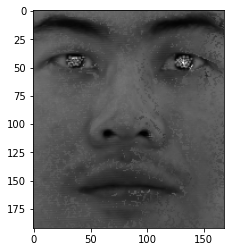

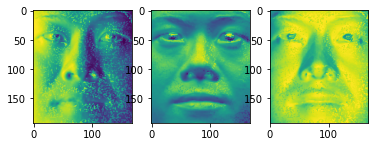

Integrability checking
Number of outliers: 19669

(192, 168)


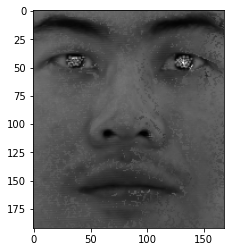

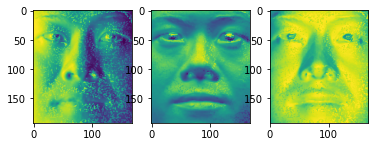

x [[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
  180 190]
 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 1

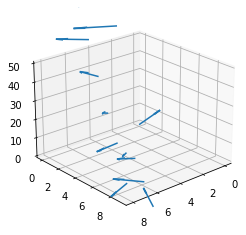

<ipython-input-304-ba8224bc602b>:146: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X,Y, H.T)


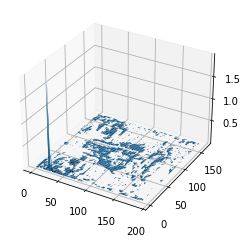

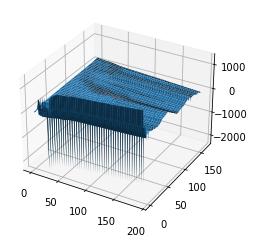

In [306]:
import numpy as np
import cv2
import os
from utils import *
# from estimate_alb_nrm import estimate_alb_nrm
# from check_integrability import check_integrability
# from construct_surface import construct_surface

print('Part 1: Photometric Stereo\n')

def photometric_stereo(image_dir='/home/zhanghh/lab1/photometric/photometrics_images/MonkeyGray', channel=0 ):

    # obtain many images in a fixed view under different illumination
    print('Loading images...\n')
    [image_stack, scriptV] = load_syn_images(image_dir, channel)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print(image_stack)

    # compute the surface gradient from the stack of imgs and light source mat
    print('Computing surface albedo and normal map...\n')
    [albedo, normals] = estimate_alb_nrm(image_stack, scriptV, shadow_trick=True)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking\n')
    [p, q, SE] = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface( p, q, 'column' )
    
    height_map_2 = construct_surface( p, q, 'row' )
    
    height_map_3 = construct_surface( p, q, 'average' )
    # show results
    show_results(albedo, normals, height_map, SE)

def photometric_stereo_color_channel(image_dir='/home/zhanghh/lab1/photometric/photometrics_images/MonkeyColor/', channel=3):
#     for i in range(channel):
    photometric_stereo(image_dir, 1)
    
## Face
def photometric_stereo_face(image_dir='/home/zhanghh/lab1/photometric/photometrics_images/yaleB02/'):
    [image_stack, scriptV] = load_face_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV, True)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface( p, q , 'row')

    # show results
    show_results(albedo, normals, height_map, SE)
    
if __name__ == '__main__':
#     photometric_stereo()
    photometric_stereo_face()
#     photometric_stereo_color_channel()

In [238]:
X = np.empty((3,4,5),dtype=int)
X.fill(2)

X[0].fill(1)
X[:,:,3].fill(4)
X[1,1].fill(9)
X[0,:,0].fill(7)
X[:,1].fill(3)
X[:,3,0].fill(6)
print(X)
X = X[...,0]
x = X[::2,::2]
print(X)
print(x)

[[[7 1 1 4 1]
  [3 3 3 3 3]
  [7 1 1 4 1]
  [6 1 1 4 1]]

 [[2 2 2 4 2]
  [3 3 3 3 3]
  [2 2 2 4 2]
  [6 2 2 4 2]]

 [[2 2 2 4 2]
  [3 3 3 3 3]
  [2 2 2 4 2]
  [6 2 2 4 2]]]
[[7 3 7 6]
 [2 3 2 6]
 [2 3 2 6]]
[[7 7]
 [2 2]]


In [ ]:
import numpy as np
import cv2
import rgbConversions
from visualize import *

def ConvertColourSpace(input_image, colourspace):
    '''
    Converts an RGB image into a specified color space, visualizes the
    color channels and returns the image in its new color space.

    Colorspace options:
      opponent
      rgb -> for normalized RGB
      hsv
      ycbcr
      gray

    P.S: Do not forget the visualization part!
    '''

    # Convert the image into double precision for conversions
    input_image = input_image.astype(np.float32)

    if colourspace.lower() == 'opponent':
        # fill in the rgb2opponent function
        new_image = rgbConversions.rgb2opponent(input_image)

    elif colourspace.lower() == 'rgb':
        # fill in the rgb2opponent function
        new_image = rgbConversions.rgb2normedrgb(input_image)

    elif colourspace.lower() == 'hsv':
        # use built-in function from opencv
        HSV = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV) 
        pass

    elif colourspace.lower() == 'ycbcr':
        # use built-in function from opencv
        YCbCr = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB).
        pass

    elif colourspace.lower() == 'gray':
        # fill in the rgb2opponent function
        new_image = rgbConversions.rgb2grays(input_image)

    else:
        print('Error: Unknown colorspace type [%s]...' % colourspace)
        new_image = input_image

    visualize(new_image)

    return new_image


if __name__ == '__main__':
    # Replace the image name with a valid image
    img_path = 'test.png'
    # Read with opencv
    I = cv2.imread(img_path)
    # Convert from BGR to RGB
    # This is a shorthand.
    I = I[:, :, ::-1]
    G, B, R = cv2.split(I)

    out_img = ConvertColourSpace(I, 'opponent.png')